# Feature exploration

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Some hyperparameters

MODEL = "gelu-1l"
RUN = "run1"
DD = f"../data/processed/{MODEL}_{RUN}_audit"

BATCH_SIZE = 128

In [3]:
import os
import torch

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sprint.loading import load_all
from sprint.feature_exploration import max_activating_examples
from sprint.visualization import visualize_topk


/opt/conda/envs/sprint/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
model, data, _ = load_all()

Loaded pretrained model gelu-1l into HookedTransformer
Moving model to device:  cuda
Changing model dtype to torch.float16
Model device: cuda:0
Tokens shape: torch.Size([215402, 128]), dtype: torch.int64, device: cuda:0
{'batch_size': 4096,
 'beta1': 0.9,
 'beta2': 0.99,
 'buffer_batches': 12288,
 'buffer_mult': 384,
 'buffer_size': 1572864,
 'd_mlp': 2048,
 'dict_mult': 8,
 'enc_dtype': 'fp32',
 'l1_coeff': 0.0003,
 'lr': 0.0001,
 'model_batch_size': 512,
 'num_tokens': 2000000000,
 'seed': 52,
 'seq_len': 128}
Encoder device: cuda:0


In [7]:
# def max_activating_examples(feature_id, n_examples, model=model, data=data, return_feature_values=False):
#     # Load feature vector
#     features = torch.load(os.path.join(DD, "feature_vectors_merged", f"{feature_id}_full.pt")).to_dense()

#     # Find the top n_examples examples that activate the feature the most
#     top_examples = torch.topk(features.flatten(), n_examples, dim=0)
#     n = features.shape[1]

#     r = top_examples.indices // n
#     c = top_examples.indices % n

#     if return_feature_values:
#         return data[r], features[r]
#     else:
#         return data[r]

# pd.DataFrame(max_activating_examples(4542, 10))

ex, val = max_activating_examples(4542, 10, return_feature_values=True, model=model, data=data)

In [8]:
# Turn into strings

[model.tokenizer.decode(x) for x in ex]

['<|BOS|> how thoroughly they answer your questions and try to get a general sense of whether they have your best interests in mind. Since prices vary among various corporate car service, it is vital to know the amount that you are expected to pay before you book a trip with the corporate ground transportation company since this will enable you to get the best value for your business.\nIt is also advisable that when looking for a corporate ground car rental company for your CEO consider looking at what the company’s previous clients are saying about the services that the company offers, such information can be obtained on the company’s website on the client review section.<|EOS|>',
 '<|BOS|> mixed_samples, mixed_sequence\n<|EOS|>In order to acquire Bresso Console Table By MEBLE NOVA, look for high quality hardwood joinery. In case a item is fixed together or if perhaps nails and screws are utilized to keep your furniture piece with each other, it will not previous extended. It is best 

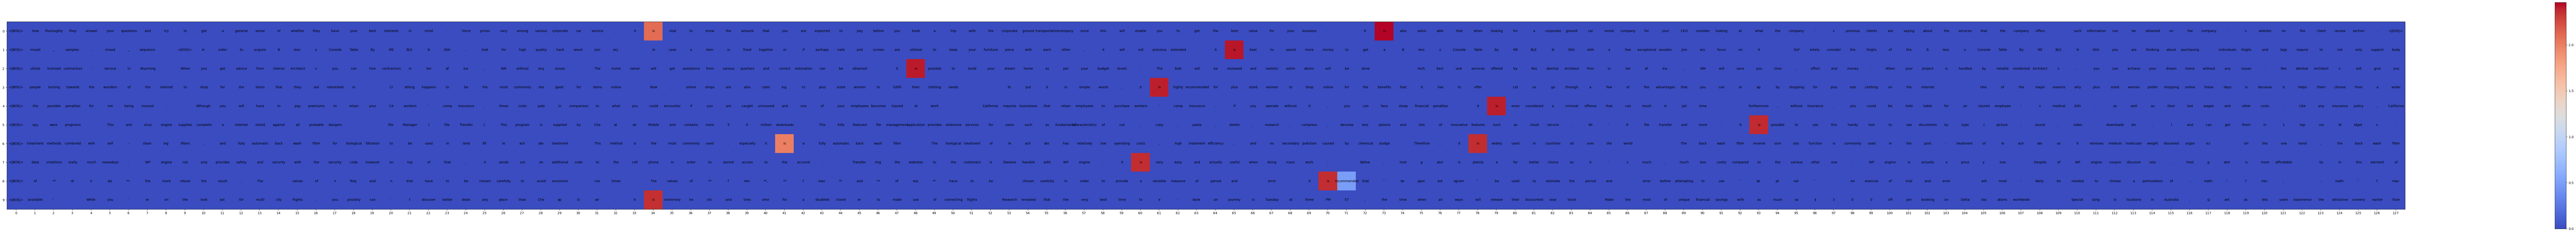

In [9]:
# Turn into a dataframe: use ex to get tokens, and val to get colors

df = pd.DataFrame([[model.tokenizer.decode(x) for x in row] for row in ex])

fig = plt.figure(figsize=(128, 10))
plt.imshow(val.cpu(), cmap="coolwarm", vmin=0)
plt.colorbar()

for i, row in df.iterrows():
    for j, token in enumerate(row):
        plt.text(j, i, token, ha="center", va="center")


plt.xticks(np.arange(0, 128))
plt.yticks(np.arange(0, 10))
plt.tight_layout()

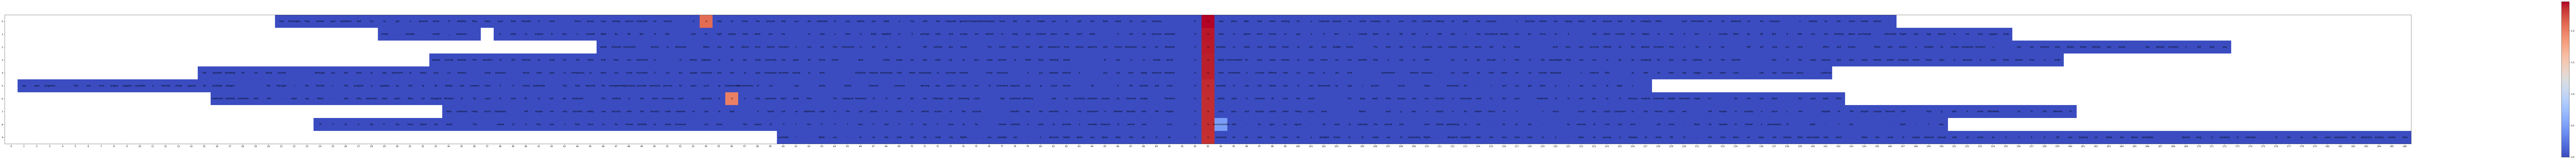

In [10]:
# Same thing, but left/right padding the tokens so that the top activations are aligned

max_val_idx = val.argmax(dim=1)
min_idx, max_idx = max_val_idx.min().item(), max_val_idx.max().item()
n_samples, n_tokens = val.shape

ex_padded = []
vals_padded = []


for i in range(n_samples):
    row_max = max_val_idx[i].item()
    ex_padded.append(
        torch.cat(
            [
                torch.zeros(max_idx - row_max, dtype=torch.int),
                ex[i].cpu(),
                torch.zeros(row_max - min_idx, dtype=torch.int),
            ]
        )
    )
    vals_padded.append(
        torch.cat(
            [
                torch.zeros(max_idx - row_max, dtype=torch.int),
                val[i].cpu(),
                torch.zeros(row_max - min_idx, dtype=torch.int),
            ]
        )
    )

ex_padded = torch.stack(ex_padded)
vals_padded = torch.stack(vals_padded)
vals_padded[ex_padded < 2] = torch.nan

# Plot
df = pd.DataFrame([[model.tokenizer.decode(x) for x in row] for row in ex_padded])

fig = plt.figure(figsize=(df.shape[1], df.shape[0]))
plt.imshow(vals_padded, cmap="coolwarm", vmin=0)
plt.colorbar()

for i, row in df.iterrows():
    for j, token in enumerate(row):
        if token not in ["<|EOS|>", "<|PAD|>", "<|BOS|>"]:
            plt.text(j, i, token, ha="center", va="center")


plt.xticks(np.arange(0, df.shape[1]))
plt.yticks(np.arange(0, df.shape[0]))
plt.tight_layout()

In [12]:


visualize_topk(4542, 10, pad=True, model=model, data=data)

NameError: name 'model' is not defined

Loaded pretrained model gelu-1l into HookedTransformer
Moving model to device:  cuda
Changing model dtype to torch.float16
Model device: cuda:0
Tokens shape: torch.Size([215402, 128]), dtype: torch.int64, device: cuda:0


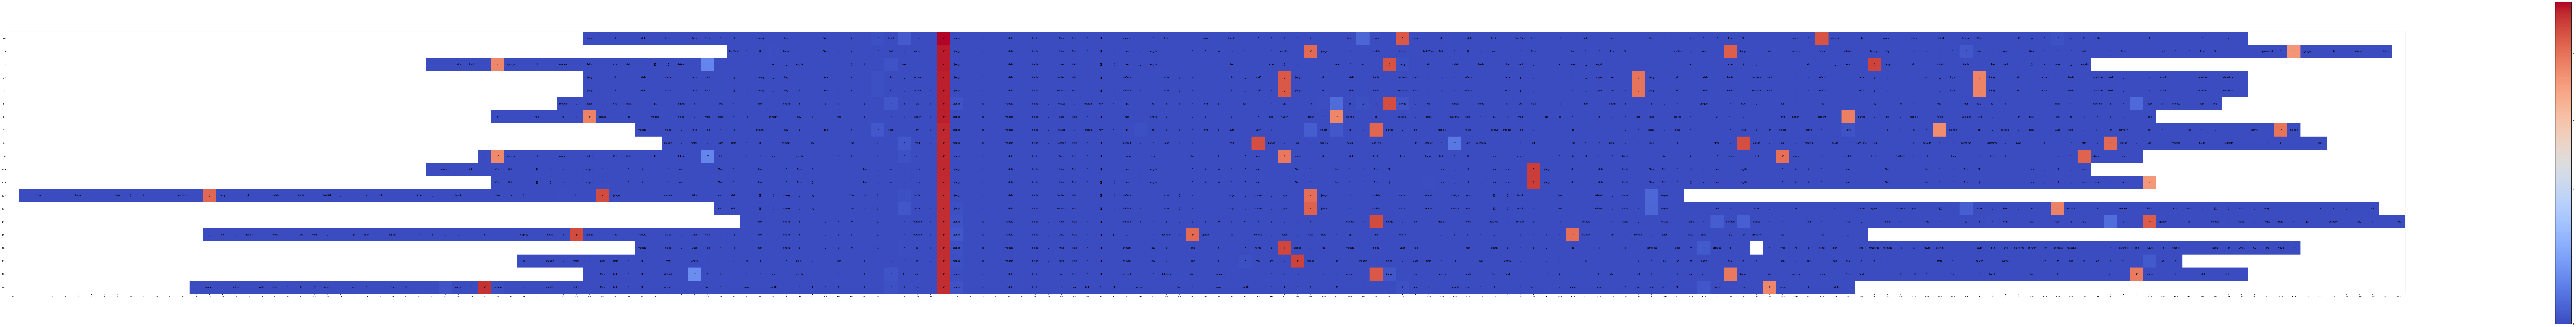

In [16]:
visualize_topk(8, 20, pad=True, model=model)

In [16]:
model.blocks[0]

TransformerBlock(
  (ln1): LayerNormPre(
    (hook_scale): HookPoint()
    (hook_normalized): HookPoint()
  )
  (ln2): LayerNormPre(
    (hook_scale): HookPoint()
    (hook_normalized): HookPoint()
  )
  (attn): Attention(
    (hook_k): HookPoint()
    (hook_q): HookPoint()
    (hook_v): HookPoint()
    (hook_z): HookPoint()
    (hook_attn_scores): HookPoint()
    (hook_pattern): HookPoint()
    (hook_result): HookPoint()
  )
  (mlp): MLP(
    (hook_pre): HookPoint()
    (hook_post): HookPoint()
  )
  (hook_attn_in): HookPoint()
  (hook_q_input): HookPoint()
  (hook_k_input): HookPoint()
  (hook_v_input): HookPoint()
  (hook_mlp_in): HookPoint()
  (hook_attn_out): HookPoint()
  (hook_mlp_out): HookPoint()
  (hook_resid_pre): HookPoint()
  (hook_resid_mid): HookPoint()
  (hook_resid_post): HookPoint()
)

In [15]:
model.blocks[0].mlp(model.blocks[0].torch.rand(512))

RuntimeError: einsum(): the number of subscripts in the equation (3) does not match the number of dimensions (1) for operand 0 and no ellipsis was given